# ISLP Chapter 6 Lab

## Importing Libraries

In [1]:
pip install ISLP

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 3.6 MB 226 kB/s eta 0:00:01
     |████████████████████████████████| 66.5 MB 237 kB/s eta 0:00:01
     |████████████████████████████████| 11.1 MB 200 kB/s eta 0:00:01    |██████████████▏                 | 4.9 MB 183 kB/s eta 0:00:34
     |████████████████████████████████| 931 kB 69 kB/s eta 0:00:011
     |████████████████████████████████| 301 kB 118 kB/s eta 0:00:01
     |████████████████████████████████| 819 kB 190 kB/s eta 0:00:01
     |████████████████████████████████| 30.3 MB 186 kB/s eta 0:00:01
     |████████████████████████████████| 11.3 MB 238 kB/s eta 0:00:01
     |████████████████████████████████| 5.3 MB 155 kB/s eta 0:00:01
     |████████████████████████████████| 349 kB 123 kB/s eta 0:00:01
     |████████████████████████████████| 8.1 MB 200 kB/s eta 0:00:01
     |████████████████████████████████| 522 kB 305 kB/s eta 0:00:01
     |██████████████████████████████

In [3]:
pip install l0bnb

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 79 kB 958 kB/s eta 0:00:01
     |████████████████████████████████| 2.7 MB 124 kB/s eta 0:00:01
     |████████████████████████████████| 28.8 MB 231 kB/s eta 0:00:01
  Created wheel for l0bnb: filename=l0bnb-1.0.0-py3-none-any.whl size=22320 sha256=4ff747c7bc1c2a724f645418f0deae85a275cb956ee5fb561a7ceeafd0d1f7d4
  Stored in directory: /Users/abigaillee/Library/Caches/pip/wheels/1f/e8/9a/bfaa7df5841a0f3512630288d62684d075aa1674b6c5c04fb2
Successfully built l0bnb
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
(Stepwise, sklearn_selected, sklearn_selection_path)

from l0bnb import fit_path

## Subset Selection Methods

Forward and backward selection have been done before. This time the Cp statistic is used. Cp is proportional to AIC in the case of a linear model and is defined as 
Cp = 1/n[RSS + 2d(sigma)^2] where d is the total n of parameters and sigma^2 is the variance of the error of each fitted value. 

### Forward Selection

In [4]:
# load dataset
Hitters  = load_data('Hitters')
# drop NA values
Hitters = Hitters.dropna()
Hitters.shape

(263, 20)

Cp is not a statistic in `sklearn`, so we must define a function to compute its negative, since we are looking for the lowest absolute value of Cp. 

In [5]:
# negative Cp
def nCp(sigma2, estimator, X, Y):
    n, p = X.shape
    # p would be d in the equation above
    Yhat = estimator.predict(X)
    # residual sum of squares
    RSS = np.sum((Y-Yhat)**2)
    return -(RSS + 2 * p * sigma2)/n

Sigma^2 wil be estimated using the MSE of the biggest model possible

In [1]:
design = MS(Hitters.columns.drop('Salary')).fit(Hitters)
Y = np.array(Hitters['Salary'])
X = design.transform(Hitters)
sigma2 = OLS(Y, X).fit().scale
sigma2

NameError: name 'MS' is not defined

In [7]:
# last three arguments of nCp - estimator, X and Y
neg_Cp = partial(nCp, sigma2)
# neg_Cp is now the scorer for model selection

In [8]:
# first peak is forward selection
strategy = Stepwise.first_peak(
    design, 
    direction = 'forward',
    max_terms = len(design.terms)
)

In [9]:
# after defining stepwise selection strategy, we can fit a regression model with forward selection
# sklearn_selected takes a model, search strategy, and selects the best model in a greedy sense
# default scoring is MSE, which increases with the number of p, resulting in a final model with all variables
hitters_MSE = sklearn_selected(
    OLS, strategy
)

In [10]:
hitters_MSE.fit(Hitters, Y)
hitters_MSE.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

In [11]:
# as expected, negCp results in a smaller model of 10 variables
hitters_Cp = sklearn_selected(
    OLS, strategy, scoring = neg_Cp
)
hitters_Cp.fit(Hitters, Y)
hitters_Cp.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

#### Choosing Using Validation/Cross-Validation
In order to conduct forward selection using cross-validation, we need to store the full path of models for predictions on unseen data. We can produce cross-validated predictions for each model along this path, and evalute the cross-validated MSE. We select the best model at each step using the biggest reduction in RSS. 

In [12]:
strategy = Stepwise.fixed_steps(
    design, len(design.terms), 
    direction = 'forward'
)
full_path = sklearn_selection_path(OLS, strategy)
#fit full path on Hittesr and compute predictions
full_path.fit(Hitters, Y)
Yhat_in = full_path.predict(Hitters)
Yhat_in.shape

(263, 20)

In [13]:
Yhat_in

array([[ 535.92588213,  602.03516506,  505.03086087, ...,  372.19029353,
         361.43503052,  362.13606585],
       [ 535.92588213,  484.97403646,  564.66713304, ...,  706.17406201,
         712.13809677,  712.6952059 ],
       [ 535.92588213,  937.39947944,  995.59888206, ..., 1166.41289971,
        1171.29048328, 1171.31111145],
       ...,
       [ 535.92588213,  348.13906857,  432.11115796, ...,  247.09365751,
         245.71268797,  243.69097639],
       [ 535.92588213,  606.78088649,  717.12346513, ..., 1026.13008776,
        1023.92340166, 1023.30029814],
       [ 535.92588213,  556.95081148,  759.48176151, ...,  708.6674326 ,
         703.9112215 ,  705.7780666 ]])

Because it is in-sample, the MSE will increase with the n of parameters. Refining the number of steps thus requires us to use validation or cross-validation on unseen data.

(50000.0, 250000.0)

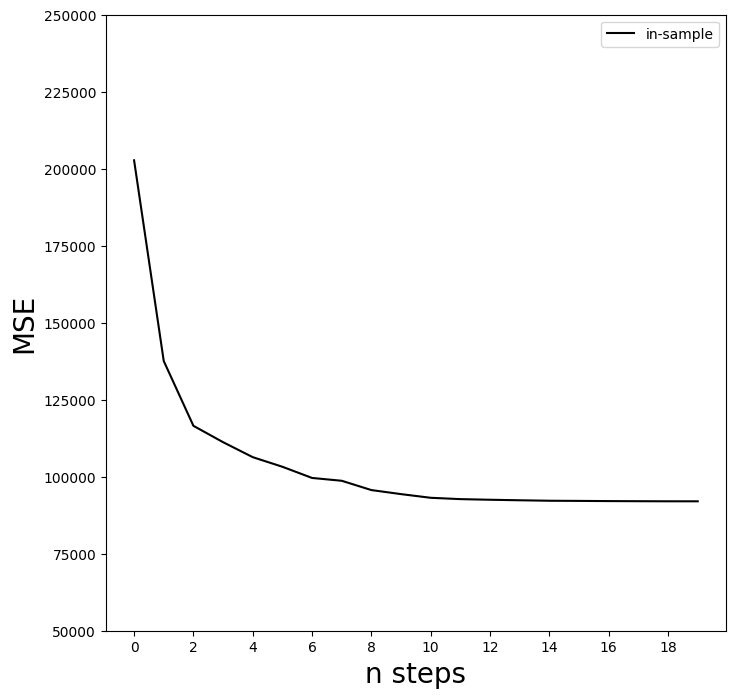

In [14]:
mse_fig, ax = subplots(figsize = (8, 8))
insample_mse = ((Yhat_in - Y[:, None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(
    np.arange(n_steps),
    insample_mse,
    'k',
    label = 'in-sample'
)
ax.set_ylabel('MSE', fontsize = 20)
ax.set_xlabel('n steps', fontsize = 20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim([50000, 250000])

Only training observations can be used when cross-validating the n of steps in variable selection. 

In [15]:
K = 5
kfold = skm.KFold(
    K, random_state = 0, shuffle = True
)
Yhat_cv = skm.cross_val_predict(full_path, Hitters, Y, cv = kfold)
Yhat_cv.shape

KeyboardInterrupt: 

In [16]:
# we compute MSE for each model at each step
# we can average MSE for a certain model
cv_mse = []
for train_idx, test_idx in kfold.split(Y):
    errors = (Yhat_cv[test_idx]-Y[test_idx, None])**2
    cv_mse.append(errors.mean(0))
cv_mse = np.array(cv_mse).T
cv_mse.shape

NameError: name 'Yhat_cv' is not defined

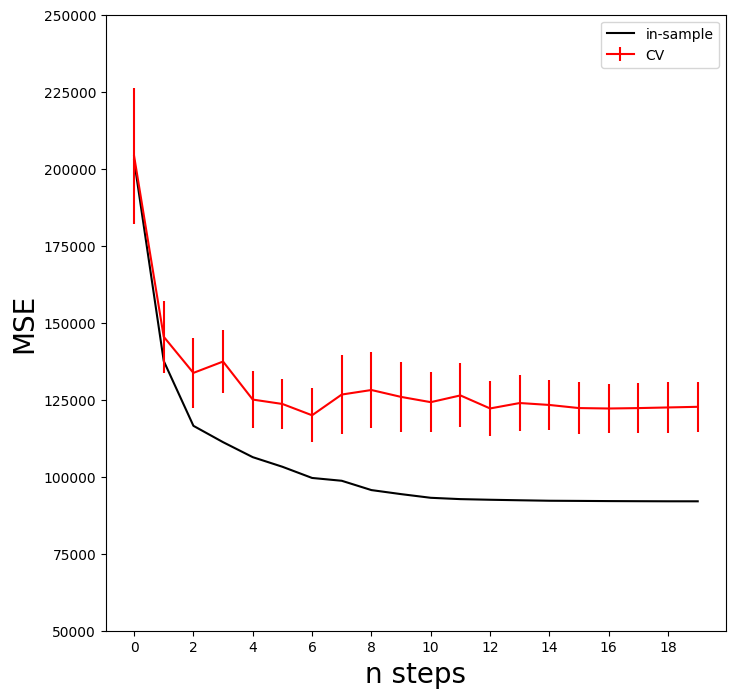

In [ ]:
ax.errorbar(
    np.arange(n_steps),
    cv_mse.mean(1),
    # standard error
    cv_mse.std(1)/np.sqrt(K),
    label = 'CV',
    c= 'r'
)
ax.set_ylim([50000, 250000])
ax.legend()
mse_fig

Cross-validation error for each model at each step of the selection process to select the model k with the lowest test error has advantages over using other statistics because we do not need to calculate sigma^2 and have a standard error. 
One-standard-error concept means that we do not choose the model with minimum test error but the simplest model with a test error within one standard error of the minimum value - because of parametric assumptions of normality we can take this as approximate for the model with the lowest test error. 

In [ ]:
#

NameError: name 'skm' is not defined

### Best Subset Selection

In [17]:
D = design.fit_transform(Hitters)
D = D.drop('intercept', axis=1)
X = np.asarray(D)
path = fit_path(X, Y, max_nonzeros = X.shape[1])
path[3]

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  2
Iteration: 4. Number of non-zeros:  2
Iteration: 5. Number of non-zeros:  3
Iteration: 6. Number of non-zeros:  3
Iteration: 7. Number of non-zeros:  4
Iteration: 8. Number of non-zeros:  9
Iteration: 9. Number of non-zeros:  9
Iteration: 10. Number of non-zeros:  9
Iteration: 11. Number of non-zeros:  9
Iteration: 12. Number of non-zeros:  9
Iteration: 13. Number of non-zeros:  9
Iteration: 14. Number of non-zeros:  9
Iteration: 15. Number of non-zeros:  9
Iteration: 16. Number of non-zeros:  9
Iteration: 17. Number of non-zeros:  9
Iteration: 18. Number of non-zeros:  17
Iteration: 19. Number of non-zeros:  19


{'B': array([0.        , 3.25484367, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.67775265, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 'B0': -38.98216739555551,
 'lambda_0': 0.011416248027450178,
 'M': 0.5829861733382012,
 'Time_exceeded': False}

## Ridge and Lasso Regression

### Ridge Regression
Because we must standardize variables for ridge/lasso regression, we must unstandardize to interpret coefficient estimates. 

In [20]:
Xs = X - X.mean(0)[None,:]
X_scale = X.std(0)
Xs = Xs/X_scale[None,:]
lambdas = 10**np.linspace(8, -2, 100) / Y.std()
soln_array = skl.ElasticNet.path(
    Xs, Y, l1_ratio = 0, alphas = lambdas
)[1]
soln_array.shape

/Users/abigaillee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/abigaillee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64428165.36474803, tolerance: 12885.7065737425
  model = cd_fast.enet_coordinate_descent_gram(
/Users/abigaillee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/abigaillee/Library/Python/3.9/lib/python/site-packa

(19, 100)

In [ ]:
# 100 columns for each value of lambda
# 19 rows for each parameter
# each data value is the coefficient values in the equation for L2 with the given lambda.  for the lambda and parameter?
soln_array

array([[ 8.00310363e-04,  1.00986867e-03,  1.27429625e-03, ...,
        -2.90923382e+02, -2.90958537e+02, -2.90986528e+02],
       [ 8.89318672e-04,  1.12218451e-03,  1.41602291e-03, ...,
         3.37260446e+02,  3.37377455e+02,  3.37470648e+02],
       [ 6.95410715e-04,  8.77500619e-04,  1.10726717e-03, ...,
         3.75180641e+01,  3.75871222e+01,  3.76420770e+01],
       ...,
       [ 5.15666738e-05,  6.50694021e-05,  8.21076995e-05, ...,
         5.36633570e+01,  5.36777586e+01,  5.36891521e+01],
       [-1.09496252e-05, -1.38170424e-05, -1.74354208e-05, ...,
        -2.21910710e+01, -2.21848930e+01, -2.21799639e+01],
       [-5.74274914e-06, -7.24531429e-06, -9.14061794e-06, ...,
        -1.23832054e+01, -1.23761905e+01, -1.23705867e+01]])

In [22]:
soln_path = pd.DataFrame(soln_array.T,
columns=D.columns,
index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
negative log(lambda),,,,,,,,,,,,,,,,,,,
-12.310855,0.000800,0.000889,0.000695,0.000851,0.000911,0.000900,0.000812,0.001067,0.001113,0.001064,0.001141,0.001149,0.000993,-0.000029,-0.000390,0.000609,0.000052,-0.000011,-0.000006
-12.078271,0.001010,0.001122,0.000878,0.001074,0.001150,0.001135,0.001025,0.001346,0.001404,0.001343,0.001439,0.001450,0.001253,-0.000037,-0.000492,0.000769,0.000065,-0.000014,-0.000007
-11.845686,0.001274,0.001416,0.001107,0.001355,0.001451,0.001433,0.001293,0.001698,0.001772,0.001694,0.001816,0.001830,0.001581,-0.000046,-0.000621,0.000970,0.000082,-0.000017,-0.000009
-11.613102,0.001608,0.001787,0.001397,0.001710,0.001831,0.001808,0.001632,0.002143,0.002236,0.002138,0.002292,0.002309,0.001995,-0.000058,-0.000784,0.001224,0.000104,-0.000022,-0.000012
-11.380518,0.002029,0.002255,0.001763,0.002158,0.002310,0.002281,0.002059,0.002704,0.002821,0.002698,0.002892,0.002914,0.002517,-0.000073,-0.000990,0.001544,0.000131,-0.000028,-0.000015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.784658,-290.823989,336.929968,37.322686,-59.748520,-26.507086,134.855915,-17.216195,-387.775826,89.573601,-12.273926,476.079273,257.271255,-213.124780,31.258215,-58.457857,78.761266,53.622113,-22.208456,-12.402891
10.017243,-290.879272,337.113713,37.431373,-59.916820,-26.606957,134.900549,-17.108041,-388.458404,89.000707,-12.661459,477.031349,257.966790,-213.280891,31.256434,-58.448850,78.761240,53.645147,-22.198802,-12.391969
10.249827,-290.923382,337.260446,37.518064,-60.051166,-26.686604,134.936136,-17.022194,-388.997470,88.537380,-12.971603,477.791860,258.523025,-213.405740,31.254958,-58.441682,78.761230,53.663357,-22.191071,-12.383205


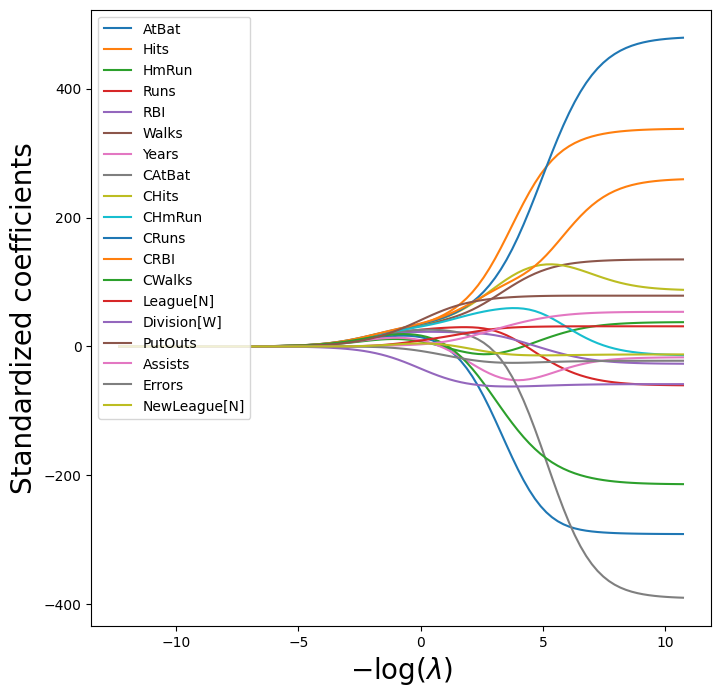

In [23]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)
ax.legend(loc='upper left');

In [25]:
ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0)
scaler = StandardScaler(with_mean=True, with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
pipe.fit(X, Y)
np.linalg.norm(ridge.coef_)

/Users/abigaillee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.446e+07, tolerance: 5.332e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


160.4237101772591

Magnitude of coefficients approaches zero as value of lambda is larger - coefficients could also change direction depending on value of lambda

### Estimating Test Error for Ridge Regression

Hyperparameter tuning using validation or cross-validation

In [26]:
validation = skm.ShuffleSplit(
    n_splits = 1,
    test_size = 0.5, 
    random_state = 0
)

ridge.alpha = 0.01
results = skm.cross_validate(
    ridge, X, Y, scoring = 'neg_mean_squared_error',
    cv = validation
)
-results['test_score']

/Users/abigaillee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.486e+06, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


array([134214.00419204])

A null model would be achieved using a very large value of lambda. 

In [28]:
param_grid = {'ridge__alpha':lambdas}
grid = skm.GridSearchCV(pipe, 
                        param_grid, 
                        cv=validation,
                        scoring = 'neg_mean_squared_error')
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_

/Users/abigaillee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+07, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/abigaillee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+07, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of th

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.005899006046740856, l1_ratio=0))])

In [29]:
# 5 fold cv
grid = skm.GridSearchCV(
    pipe, 
    param_grid, 
    cv = kfold, 
    scoring = 'neg_mean_squared_error'
)
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_

/Users/abigaillee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e+07, tolerance: 3.759e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/abigaillee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.101e+07, tolerance: 4.201e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of th

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.01185247763144249, l1_ratio=0))])

In [30]:
grid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.01185247763144249, l1_ratio=0))])

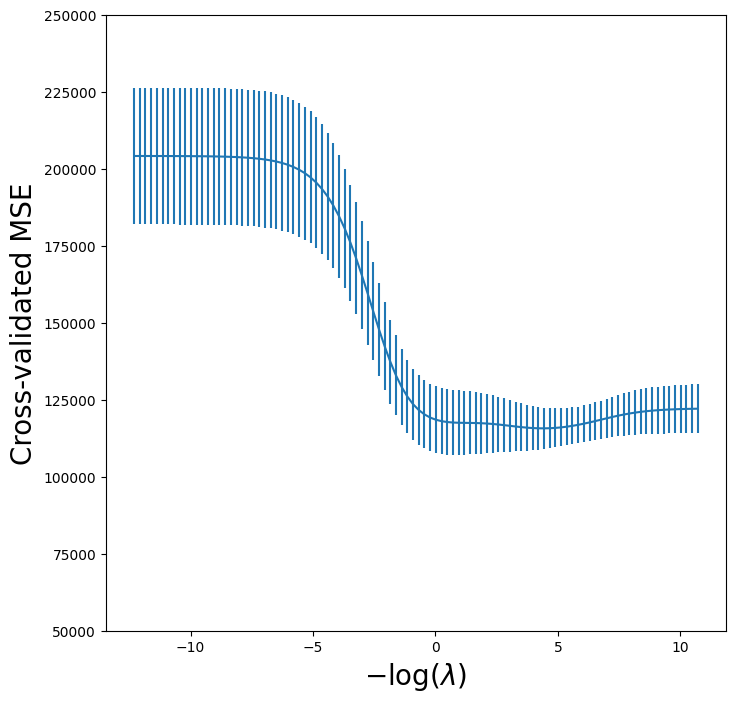

In [31]:
ridge_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
-grid.cv_results_['mean_test_score'],
yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylim([50000,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

Really using induction to find best fit for lambda parameter for the least test error

In [32]:
grid_r2 = skm.GridSearchCV(pipe,
param_grid,
cv=kfold)
grid_r2.fit(X, Y)

/Users/abigaillee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e+07, tolerance: 3.759e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/abigaillee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.101e+07, tolerance: 4.201e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of th

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge',
                                        ElasticNet(alpha=0.01, l1_ratio=0))]),
             param_grid={'ridge__alpha': array([2.22093791e+05, 1.76005531e+05, 1.39481373e+05, 1.10536603e+05,
       8.75983676e+04, 6.94202082e+04, 5.50143278e+04, 4.35979140e+04,
       3.45506012e+04, 2.73807606e+04, 2.16...
       4.67486141e-03, 3.70474772e-03, 2.93594921e-03, 2.32668954e-03,
       1.84386167e-03, 1.46122884e-03, 1.15799887e-03, 9.17694298e-04,
       7.27257037e-04, 5.76338765e-04, 4.56738615e-04, 3.61957541e-04,
       2.86845161e-04, 2.27319885e-04, 1.80147121e-04, 1.42763513e-04,
       1.13137642e-04, 8.96596467e-05, 7.10537367e-05, 5.63088712e-05,
       4.46238174e-05, 3.53636122e-05, 2.80250579e-05, 2.22093791e-05])})

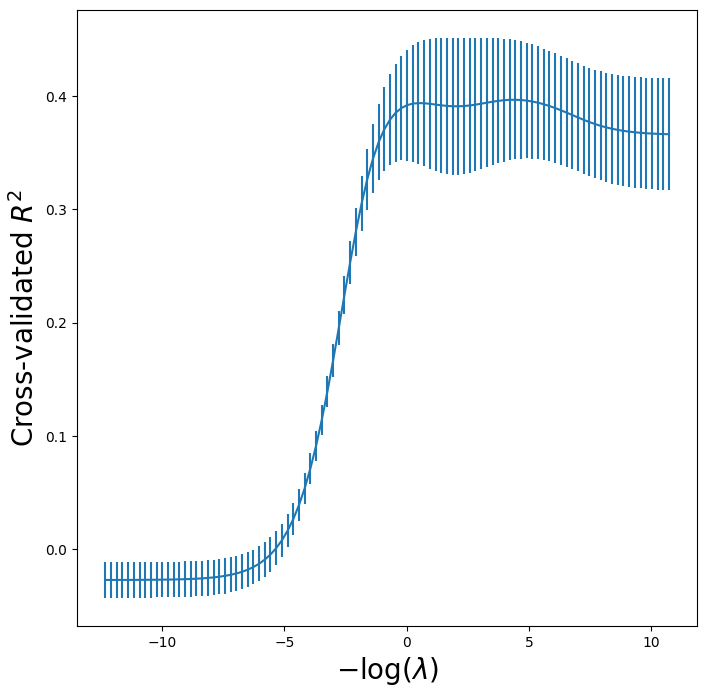

In [33]:
r2_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
grid_r2.cv_results_['mean_test_score'],
yerr=grid_r2.cv_results_['std_test_score'] / np.sqrt(K)
)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated $R^2$', fontsize=20);

#### Fast CV for Solution Paths
The ridge, lasso, and elastic net can be efciently ft along a sequence of
λ values, creating what is known as a solution path or regularization path.
Hence there is specialized code to ft such paths, and to choose a suitable
value of λ using cross-validation. Even with identical splits the results will
not agree exactly with our grid above because the standardization of each
feature in grid is carried out on each fold, while in pipeCV below it is carried
out only once

In [34]:
ridgeCV = skl.ElasticNetCV(
    alphas = lambdas,
    l1_ratio = 0, 
    cv= kfold
)
pipeCV = Pipeline(steps=[('scaler', scaler), ('ridge', ridgeCV)])
pipeCV.fit(X, Y)

/Users/abigaillee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/abigaillee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18795326.355502333, tolerance: 3759.109166869193
  model = cd_fast.enet_coordinate_descent_gram(
/Users/abigaillee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/abigaillee/Library/Python/3.9/lib/python/site-pac

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNetCV(alphas=array([2.22093791e+05, 1.76005531e+05, 1.39481373e+05, 1.10536603e+05,
       8.75983676e+04, 6.94202082e+04, 5.50143278e+04, 4.35979140e+04,
       3.45506012e+04, 2.73807606e+04, 2.16987845e+04, 1.71959156e+04,
       1.36274691e+04, 1.07995362e+04, 8.55844774e+03, 6.78242347e+03,
       5.37495461e+03, 4.25955961e+03,...
       1.84386167e-03, 1.46122884e-03, 1.15799887e-03, 9.17694298e-04,
       7.27257037e-04, 5.76338765e-04, 4.56738615e-04, 3.61957541e-04,
       2.86845161e-04, 2.27319885e-04, 1.80147121e-04, 1.42763513e-04,
       1.13137642e-04, 8.96596467e-05, 7.10537367e-05, 5.63088712e-05,
       4.46238174e-05, 3.53636122e-05, 2.80250579e-05, 2.22093791e-05]),
                              cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              l1_ratio=0))])

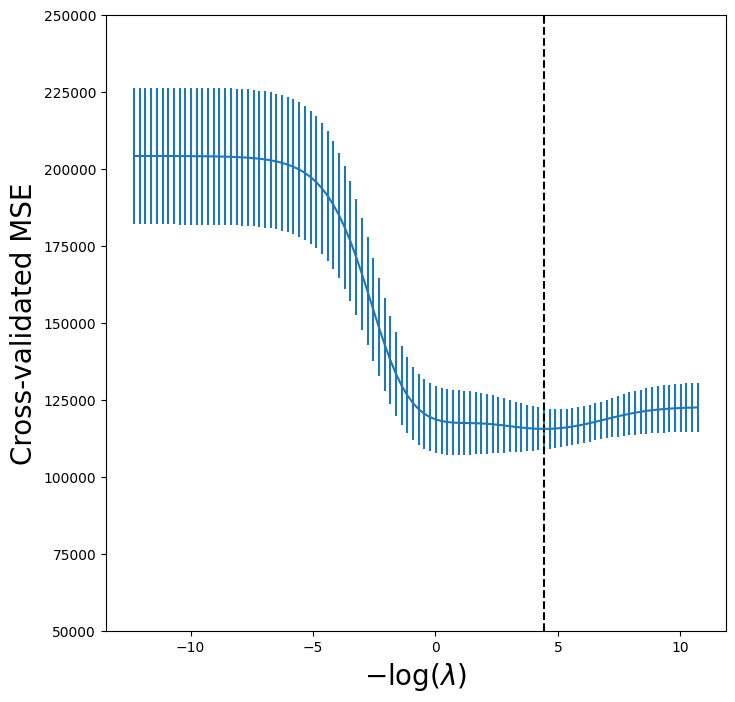

In [35]:
tuned_ridge = pipeCV.named_steps['ridge']
ridgeCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
tuned_ridge.mse_path_.mean(1),
yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
ax.set_ylim([50000,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

In [36]:
np.min(tuned_ridge.mse_path_.mean(1))

115526.70630987917

Improved MSE with this pipeline

#### Test Error of CV Ridge
Because you obtain a ridge regression model through CV, but you cannot have the training of this model touch test data, you would have to perform CV on training data to create model and test it on unseen data. So you would split the data into a higher margin of 75 to 25. 

In [37]:
outer_valid = skm.ShuffleSplit(n_splits=1,
test_size=0.25,
random_state=1)
inner_cv = skm.KFold(n_splits=5,
shuffle=True,
random_state=2)
ridgeCV = skl.ElasticNetCV(alphas=lambdas,
l1_ratio=0,
cv=inner_cv)
pipeCV = Pipeline(steps=[('scaler', scaler),
('ridge', ridgeCV)]);

In [38]:
results = skm.cross_validate(pipeCV,
X,
Y,
cv=outer_valid,
scoring='neg_mean_squared_error')
-results['test_score']

/Users/abigaillee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/abigaillee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16002961.893047336, tolerance: 3200.6325551004925
  model = cd_fast.enet_coordinate_descent_gram(
/Users/abigaillee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/abigaillee/Library/Python/3.9/lib/python/site-pa

array([132393.84003227])

### Lasso Regression
Comparing lasso with ridge regression - only difference is that `l1_ratio = 1`.

In [39]:
lassoCV = skl.ElasticNetCV(n_alphas=100,
l1_ratio=1,
cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
('lasso', lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

3.1472370031649866

In [40]:
lambdas , soln_array = skl.Lasso.path(Xs,
Y,
l1_ratio=1,
n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
columns=D.columns,
index=-np.log(lambdas))

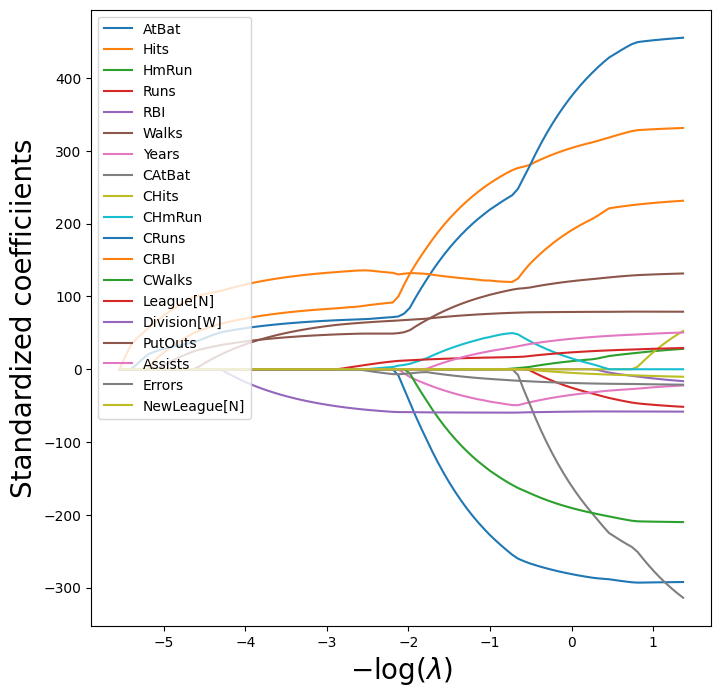

In [41]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);

Depending on lambda, some coefficients will = 0, thus performing variable selection

In [42]:
np.min(tuned_lasso.mse_path_.mean(1))

114690.73118253727

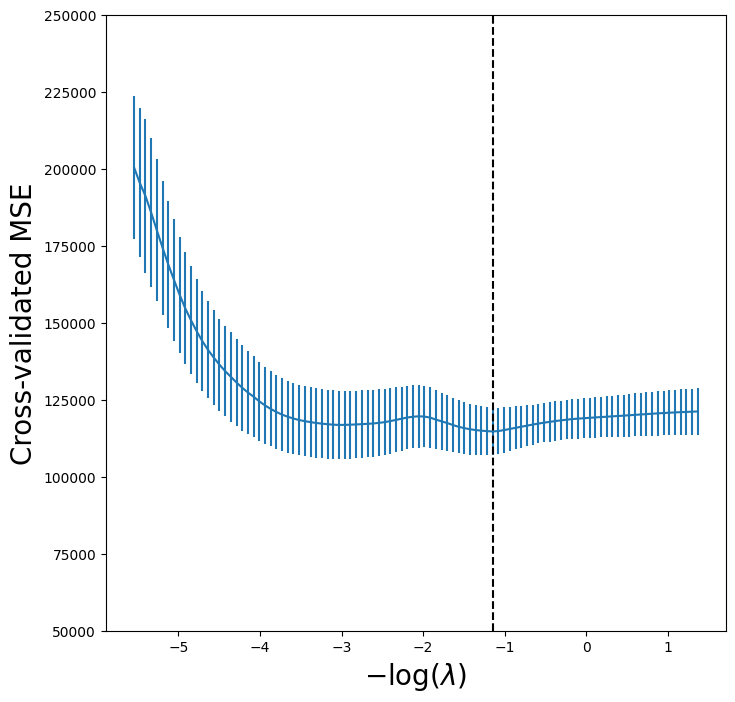

In [43]:
lassoCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
tuned_lasso.mse_path_.mean(1),
yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_ylim([50000,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

The advantage of lasso over ridge regression is that we are left with a smaller p. 

## PCR

In [44]:
pca = PCA(n_components = 2)
# first manually specifying n of components
linreg = skl.LinearRegression()
pipe = Pipeline([('pca', pca), ('linreg', linreg)])
pipe.fit(X, Y)
pipe.named_steps['linreg'].coef_

array([0.09846131, 0.4758765 ])

In [45]:
# results depend on standardisation
pipe = Pipeline([('scaler', scaler),
('pca', pca),
('linreg', linreg)])
pipe.fit(X, Y)
pipe.named_steps['linreg'].coef_

array([106.36859204,  21.60350456])

In [46]:
# hyperparameter tuning using cross-validation approach
param_grid = {'pca__n_components': range(1, 20)}
grid = skm.GridSearchCV(pipe,
param_grid,
cv=kfold,
scoring='neg_mean_squared_error')
grid.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

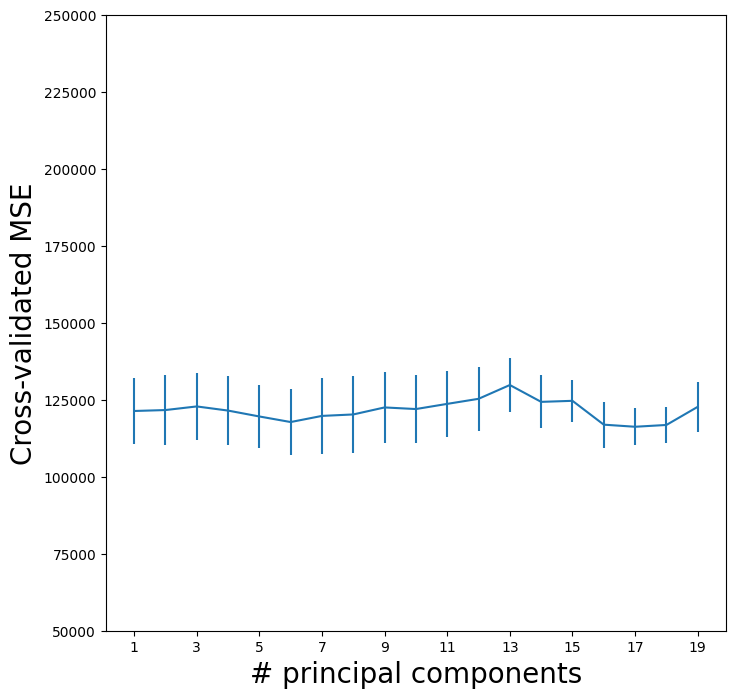

In [47]:
pcr_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['pca__n_components']
ax.errorbar(n_comp,
-grid.cv_results_['mean_test_score'],
grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2])
ax.set_ylim([50000,250000]);

Lowest CV error overall occurs when n_components = 17, however we see that the error achieved using only one component is not significantly different from this error, and we get a simpler model. So it seems like using a small number of components might just suffice. 